# IFU Cube Fitting


**Use case:** continuum and emission-line modeling of AGN; 1.47-1.87um.<br>
**Data:** [NIFS](https://www.gemini.edu/instrumentation/current-instruments/nifs) on Gemini; NGC 4151.<br>
**Tools:**  specutils, jdaviz/cubeviz, astropy, matplotlib, bottleneck.<br>
**Cross-intrument:** NIRSpec; potentially MIRI <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/IFU_cube_continuum_fit/) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>

## Introduction

This notebook uses an example 3-D IFU Datacube of the Active Galactic Nucleii NGC 4151 [Storchi-Bergmann et al. 2009,  MNRAS, V 394, pp. 1148-1166](https://ui.adsabs.harvard.edu/abs/2009MNRAS.394.1148S/abstract).  This is a ground-based AO-fed H-band dataset (1.47-1.87um) from the Near-Infrared Integral Field Spectrograph (NIFS) instrument at the Gemini Observatory.  NIFS is a very similar image slicing IFU to JWST NIRSpec.

This notebook performs some simple spectral investigations.  The notebook utilizes [jdaviz/cubviz](https://github.com/spacetelescope/jdaviz) to inspect the dataset and extract 1-D spectra.  The continuum is fit in a region near to the 1.644um [Fe II] emission from the AGN outflow and subtracted.  The centrally compact atomic Hydrogen Brackett 12 feature, which is nearby in wavelength and contaminates the [Fe II] outflow emission, is also fit and removed.  The data sub-cubes of the continuum model and the isolated and continuum subtracted [Fe II] emission are then saved.  These saved data sets will ultimately serve as starting points for the future notebooks in this set.

**Note:** This notebook is designed to analyze the 1.6440 [Fe II] emission but the wavelengths can be altered to fit and remove continuum around any emission line of interest.

## Import Packages
 - time for timing
 - numpy for array processing and math
 - matplotlib.pyplot for plotting images and spectra
 - astropy.io for reading and writing FITS cubes and images
 - astropy.modeling for modeling spectral curves
 - astropy.utils.data for accessing the data
 - specutils.fitting for spectral data fitting
 - specutils Spectrum1D for modeling emission lines
 - jdaviz.app to use cubeviz in the notebook



In [1]:
# load important packages
import time
import os
from copy import copy
from IPython.display import HTML, YouTubeVideo

import astropy
import numpy as np
from astropy.io import fits, ascii
from astropy import units as u
from astropy.modeling import models
from astropy.utils.data import download_file
from specutils.fitting import fit_lines
from specutils import Spectrum1D
from jdaviz import Cubeviz
from jdaviz.app import Application
from specutils.manipulation import extract_region
from specutils.spectra import SpectralRegion

In [2]:
# load and configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
# Save and Load Objects Using Pickle
import pickle


def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

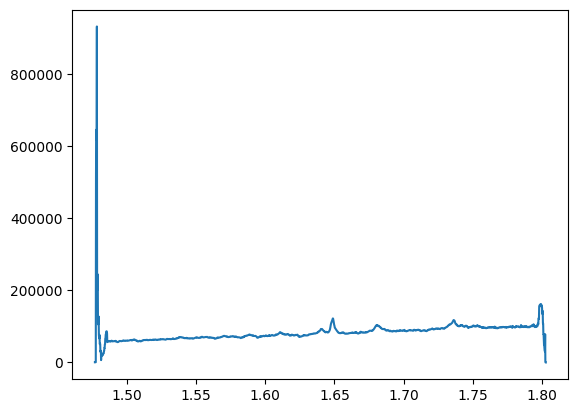

In [4]:
# This cell accesses the datacube file, defines the wavelength grid from header information and then plots a simple
# 1-D collapsed spectrum of the IFU data.

# Read in a 3-D IFU datacube of interest, and header.
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits', cache=True)
cube = fits.getdata(cube_file)
header_cube = fits.getheader(cube_file)

# grab data information and wavelength definitions.
nz, ny, nx = cube.shape
crdelt3 = header_cube['CDELT3']
crval3 = header_cube['CRVAL3']

# define the wavelength grid (microns) from the header (Angstroms)
# and the AGN redshift and the emission line of interest.
wave = ((crdelt3 * (np.arange(0, nz, 1))) + crval3)/10000.0
redshift = 0.00332
emission_line = 1.64400*(1 + redshift)
emission_line_index = (np.abs(wave-emission_line)).argmin()

# make a simple summed 1d spectrum of the full cube
flux1 = np.sum(cube, axis=(1, 2))

# plot the full 1-D spectrum.
plt.figure(0)
plt.plot(wave, flux1)
plt.show()

We see that the spectral edges of the summed 1D are 'ratty'.  The 1D spectral array goes beyond the nominal useable data range of the instrument.  We'll ignore the poor spectral regions and focus on the AGN flux.

The [Fe II] feature that we are interested in is the bright, strong emission just shortward of 1.65um.  The contaminating H I Br 12 emission is just blueward of the [Fe II].

We can use this plot window to read wavelength values of interest to define our analysis spectral ranges (see wavelength/flux grid data to the lower right of the plot window).

Special Note - in this particular dataset, a portion of the spectrum on the red side of the [FeII] emission
provides a clean measure of the continuum.  The blue-ward side of the [Fe II]
and HI Brackett 12 emission has other emission and absorption features that make clear continuum ID very 
difficult.  As a result, it is more accurate to do a simple linear fit to the red side of the spectrum rather than
a more expanded spectral region that encompasses the emission..

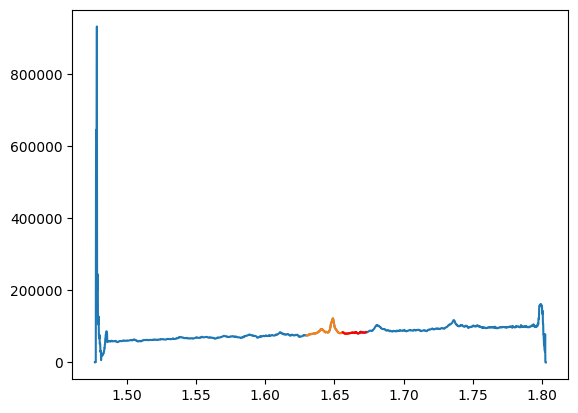

In [5]:
# This cell defines the wavelength regions of interest: around the emission line, and the location
# where you want to fit and remove the continuum very accurately.  Make a plot that shows the regions.

# Here we select a region that includes the emission line
# wavelength plus a small range of continuum around it.  
# Determine these limits by investigating the flux in the above plot.  Read
# the wavelength values off of the plot information at the lower right.

wave_emission_limit1 = 1.630
wave_emission_limit2 = 1.665

# Here we define a spectral range where we will use the
# flux to generate a continuum model.  The flux shape in this
# AGN is quite linear around the redward emission, so we will use only a 
# short segment of the spectrum on the red side of the emission 
# feature.
# We again determine these values by investigating the wavelengths in the
# above plot window.

continuum_limit1 = 1.656
continuum_limit2 = 1.673
  
# Define the wavelength region around the emission - indices
wavemin = (np.abs(wave-wave_emission_limit1)).argmin()
wavemax = (np.abs(wave-wave_emission_limit2)).argmin()

# Define the wavelength region used to fit the continuum flux level  - indices.
continuummin = (np.abs(wave-continuum_limit1)).argmin()
continuummax = (np.abs(wave-continuum_limit2)).argmin()

# Show the region used for the emission line and continuum fit.  Alter the wavelengths 
# above if this doesn't look good.  
plt.figure(1)
plt.plot(wave, flux1)
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax], color='r')
plt.show()

### Cubeviz Visualization
You can also visualize images inside a Jupyter notebook using [Cubeviz](https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html)

### Video1: 

This Cubeviz Instructional Demo is from STScI's official YouTube channel and provides an introduction to Cubeviz.

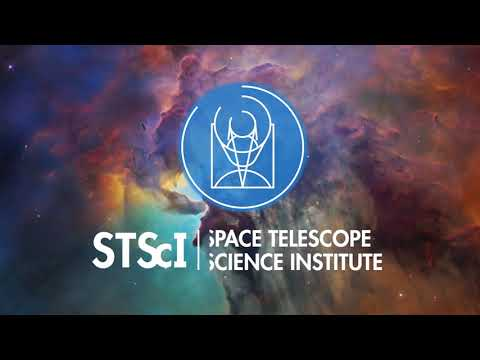

In [6]:
vid = YouTubeVideo("HMSYwiH3Gl4")
display(vid)

In [7]:
cubeviz = Cubeviz()
cubeviz.app

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html', events=[…

In [8]:
# Here, we load the data into the Cubeviz app.
cubeviz.load_data(fn) 

A video is shown below illustrating the procedure.  The following steps are applied:

When you load your cube, you will see a collapsed spectrum of all the spaxels in the spectral viewer at the bottom.

If you draw a region (circle or square) in the flux viewer, you will see a collapsed spectrum of that particular region in the spectral viewer, too.  To do this, use the expandable menu at the left of the flux viewer window and select the 'define circular region of interest' icon.  For this example, we want to first define a circular region at the central position of the bright AGN flux, which is at approximately the cube center position.

Now, use the flux viewer and again use the 'define circular region of interest' icon to make spectra at two positions associated with the outflow emission in [Fe II].  The redshifted outflow is at approximate x position = 12, y position = 36.  This will be 'Subset 2' and will show up in green in the display. The blueshifted outflow is at approximately x position = 50, y position = 28 in pixel index units.  This will be 'Subset 3' and will show up in blue in the display.

(If the notebook is being run non-interactively, automatically make two datasets that mimic the AGN outflow red/blueshifted spectra).

## Defining your Spectral Regions

Next, you will want to define the wavelengths of interest in your spectral viewer for both your line and continuum analysis.  To do this, you will similarly click the 'define region of interest' icon in your spectral viewer and drag a box over the wavelengths you desire.  Again, a video is show below illustrating the process.

There is no option to set the spectral regions to user input, so we recommend zooming in and drawing by eye.  The line emission (;Subset 4' ) should span approximately 1.630 - 1.665 um, and the continuum emission ('Subset 5') should span approximately 1.656 - 1.673 um.

### Some Notes:

*If your cell window requires you to scroll to see the different displays in cubeviz, you can toggle the scroll window in the main menu of the notebook: Cell -> Current Outputs -> Toggle Scrolling

*In the datacube viewing panel, you can select the 'layer' tab (horizontal line settings icon) in the upper panel within the viewer and change the display scaling.  Decreasing the maximum display value by 10x brings out the low level extended emission in this dataset.  In this cube, data from slice ~1060 to ~1090 shows the extended [Fe II] emission.  

### Video2: 

Here is a video illustrating how to load and manipulate data for this particular notebook.  A description of how to manipulate the data and use the "Collapse" tool is given above.

IFrame("https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz1.mov", width=700, height=500)


In [9]:
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz1.mov" frameborder="0" allowfullscreen></iframe>')

/usr/share/miniconda/lib/python3.11/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Video3:

Here is a video illustrating how to define your regions of interest and extract them into the notebook for more analysis below.

In [10]:
# PART 1
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz2_1.mov" frameborder="0" allowfullscreen></iframe>')

In [11]:
# PART 2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz2_2.mov" frameborder="0" allowfullscreen></iframe>')

# Extract Subset Spectrum in Cubeviz Spectrum Viewer

Retrieve the spectrum (Subset1) of the user-defined region from the Spectrum Viewer as a Spectrum1D object.

In [12]:
# Extract spectra corresponding to the colored regions in cubeviz
spectrum1 = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 1') # AGN Center
spectrum2 = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 2') # Red shifted component
spectrum3 = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 3') # Blue shifted component
spectrum1

        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.
        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.
        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.


{}

In [13]:
# Extract the line region defined in the spectral viewer
regions = cubeviz.specviz.get_spectral_regions()
        
if regions and "Subset 4" in regions.keys():
    line_region = regions["Subset 4"]
else:
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)

In [14]:
# Extract the continuum region defined in the spectral viewer
if regions and "Subset 5" in regions.keys():
    continuum_region = regions["Subset 5"]
else:
    continuum_region = SpectralRegion(1.656*u.um, 1.673*u.um)

In [15]:
# Apply the spectral region
# (creates new collapsed spectra if user did not in jdaviz)
if not spectrum1:
    flux_agn = np.sum(cube[:, (ny//2)-3:(ny//2)+3, (nx//2)-3:(nx//2)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_agn*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_agn = extract_region(tmpspec, line_region)
    spec_agn_continuum = extract_region(tmpspec, continuum_region)    
else: 
    spec_agn = extract_region(spectrum1, line_region)
    spec_agn_continuum = extract_region(spectrum1, continuum_region)

if not spectrum2:
    flux_feii_red = np.sum(cube[:, (36)-3:(36)+3, (12)-3:(12)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_feii_red*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_red = extract_region(tmpspec, line_region)
    spec_feii_red_continuum = extract_region(tmpspec, continuum_region)
else:    
    spec_feii_red = extract_region(spectrum2, line_region)
    spec_feii_red_continuum = extract_region(spectrum2, continuum_region)

if not spectrum3:
    flux_feii_blue = np.sum(cube[:, (28)-3:(28)+3, (50)-3:(50)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_feii_blue*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_blue = extract_region(tmpspec, line_region)
    spec_feii_blue_continuum = extract_region(tmpspec, continuum_region)
else:     
    spec_feii_blue = extract_region(spectrum3, line_region)
    spec_feii_blue_continuum = extract_region(spectrum3, continuum_region)

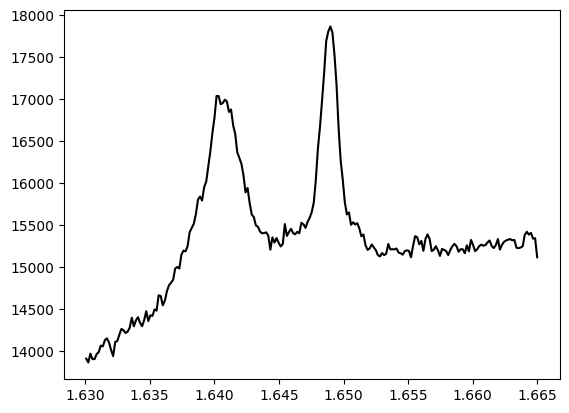

In [16]:
# Visualize new subsets
plt.figure()
plt.plot(spec_agn.spectral_axis, spec_agn.flux, color='black')

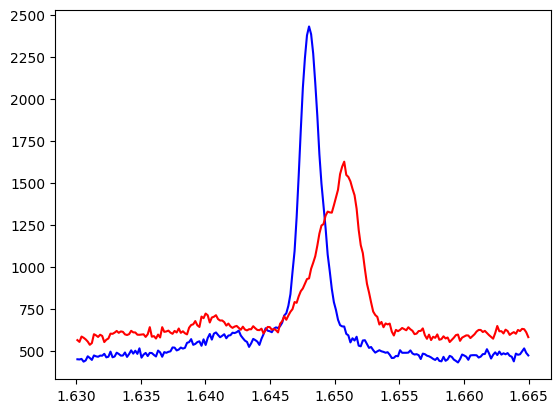

In [17]:
# Visualize new subsets
plt.figure()
plt.plot(spec_feii_blue.spectral_axis, spec_feii_blue.flux, color='b')
plt.plot(spec_feii_red.spectral_axis, spec_feii_red.flux, color='r')

## Fit the Continuum at the Spectral Region Location

A video is shown below illustrating the procedure for fitting the continuum for 'Subset 5' throughout the entire cube.  The following steps are applied to this particular example:<br />

Open up Model Fitting Plugin. There are a number of fields to fill in and drop down menus to select from.  It is important to keep in mind that the Data menu will provide only spectra to model, while the Spectral Region menu will provide only spectral region subsets to choose.  In other words, you can fit the spectra in specific spectral regions.  If no spectral region is selected, the entire wavelength array will be fit by the mode. <br />

Select Data Cube: contentsSCI <br />
Select Spectral Region Subset 5<br />
Model: Linear1D<br />
ModelID: L1<br />
Model Parameters: Leave Default<br />
Model Equation Editor: L1<br />
Model Label: LinFitCont<br />
<br />
Hit Fit, which fits the collapsed spectrum.<br />
View the fit in the spectral viewer and confirm you are happy with it. <br />
Then hit Apply to Cube.<br />

This will create two models that can now be accessed within the Data Dropdown menus:<br />
A 1D linear fit of the continuum for the collapsed cube.<br />
A 3D linear fit of the continuum for each spaxel in the cube.<br />



In [18]:
# VIDEO OF CONTINUUM FITTING
# PART 1
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/bestfitcube_p1.mov" frameborder="0" allowfullscreen></iframe>')

In [19]:
# PART 2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/bestfitcube_p2.mov" frameborder="0" allowfullscreen></iframe>')

## Pulling Data from Viewers

Note, in cubeviz, you have 4 viewers from which you can pull data.  Make sure your data are properly loaded into each viewer before executing the get_data_from_viewer command:<br />

Top Left: flux-viewer <br />
Center: uncert-viewer<br />
Top Right: mask-viewer<br />
Bottom: spectrum-viewer<br />

In [20]:
# List data from viewer
regions = cubeviz.app.get_data_from_viewer("uncert-viewer")
regions

        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.


{}

In [21]:
# Extract continuum model from Cubeviz above
cont_psf_cube = cubeviz.app.get_data_from_viewer("uncert-viewer", "LinFitCont [Cube] 1")

        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.


## Important Note: Always save data and variables when possible.

In [22]:
# Delete any existing output in current directory
if os.path.exists("NGC4151_Hband_ContinuumSubtract.fits"):
    os.remove("NGC4151_Hband_ContinuumSubtract.fits")
else:
    print("The file does not exist")

if os.path.exists("NGC4151_Hband_ContinuumPSF.fits"):
    os.remove("NGC4151_Hband_ContinuumPSF.fits")
else:
    print("The file does not exist")

In [23]:
# Subtract Continuum

# Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits', cache=True)
newheader_cube = fits.getheader(cube_file)

# Check to see if user made a continuum fit in Cubeviz, make continuum subtraction, and save output
if not cont_psf_cube:
    start_time = time.time()

    cont_sub_cube = np.zeros([nz, ny, nx])
    cont_psf_cube = np.zeros([nz, ny, nx])

    for i in range(1, nx-2):
        for j in range(1, ny-2):
            flux1 = cube[:, j, i]      
            cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
            fitval = np.poly1d(cont_fit)
            continuum = fitval(wave)        
            cont_sub_cube[:, j, i] = flux1 - continuum
            cont_psf_cube[:, j, i] = continuum 

    del newheader_cube['MODE']
    fits.writeto('NGC4151_Hband_ContinuumSubtract.fits', cont_sub_cube, newheader_cube, overwrite=True)
    fits.writeto('NGC4151_Hband_ContinuumPSF.fits', cont_psf_cube, newheader_cube, overwrite=True)
    print('Continuum subtracted cube saved. PSF continuum cube saved.')
else:
    with fits.open(newfn, memmap=False) as cont_sub_cube:
        sci = cont_sub_cube['SCI'].data

        # Get List of different viewers
        continuumflux = cont_psf_cube["flux"]

        sci_contsub = sci-continuumflux
        cont_sub_cube['SCI'].data = sci_contsub 
        del cont_sub_cube['PRIMARY'].header['MODE']
        cont_sub_cube.writeto('NGC4151_Hband_ContinuumSubtract.fits')
        del newheader_cube['MODE']
        fits.writeto('NGC4151_Hband_ContinuumPSF.fits', continuumflux, newheader_cube, overwrite=True)

Continuum subtracted cube saved. PSF continuum cube saved.


In [24]:
# You can also read out your model fit parameters 
params = cubeviz.get_model_parameters(model_label="LinFitCont")
params

{}

*(The following cell is just an example of how you can acces the model fit parameter values):*

In [25]:
# If you are using jdaviz < 3.5, uncomment the following line instead:
#params['LinFitCont_3d']['slope']
#params['LinFitCont']['slope']

In [26]:
# Open up a new instance of Cubeviz to visualize continuum subtracted data
cubeviz2 = Cubeviz()
cubeviz2.app

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html', events=[…

In [27]:
cont_sub_cube = 'NGC4151_Hband_ContinuumSubtract.fits'
cubeviz2.app.load_data(cont_sub_cube, data_label='Continuum Subtracted')

## Fitting your multiple component Gaussian Model

Now we want to investigate an initial fit to the Br 12 emission feature, which is a pesky contaminant nearby in wavelength to our target [Fe II] emission.  The Br 12 is centrally compact and arises from only from the nucleus of the AGN, not from the outflow.  Make a plot of the fit results.<br />

A video is shown below illustrating the procedure.  The following steps are applied:<br />

First, select the wavelength region of interest following a similar procedure as performed at the top.  There is no option to set the spectral regions to a user input, so we recommend zooming in and drawing by eye.  The line emission ('Subset 1' ) should again span approximately 1.630 - 1.665 um.

For this example, we recommend setting up a 3 component gaussian model with the following inputs<br />
Open up Model Fitting Plugin. There are a number of fields to fill in and drop down menus to select from.  It is important to keep in mind that the Data menu will provide only spectra to model, while the Spectral Region menu will provide only spectral region subsets to choose.  In other words, you can fit the spectra in specific spectral regions.  If no spectral region is selected, the entire wavelength array will be fit by the mode. <br />

Data: Continuum Subtracted<br />
Spectral region or subset covering about 1.632 to 1.656 um<br />
Model: Three different Gaussians with ModelID's set to G1, G2, and G3<br />
Model Parameters: <br />

G1: stdev=0.0008E-6, mean=1.641E-6<br />
G2: stdev=0.0007E-6, mean=1.648E-6<br />
G3: stdev=0.005E-6, mean=1.646E-6<br />
You can turn on the 'Fixed' option if you need to, but these numbers should provide a good starting guess for the fit.<br />

Model Equation Editor: G1+G2+g3<br />
Model Label: GaussAll<br />
<br />
Hit Fit, which fits the collapsed spectrum.<br />
View the fit in the spectral viewer and confirm you are happy with it.  Modify if necessary. <br />
Then hit Apply to Cube.<br />

This will again create two models that can now be accessed within the Data Dropdown menus:<br />
A 1D linear fit of the lines in the collapsed cube.<br />
A 3D linear fit of the lines for each spaxel in the cube.<br />

In [28]:
# VIDEO PART1
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/multifit_p1.mov" frameborder="0" allowfullscreen></iframe>')

/usr/share/miniconda/lib/python3.11/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [29]:
# VIDEO PART2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/multifit_p2.mov" frameborder="0" allowfullscreen></iframe>')

Wow, that multi-component fit looks great.  Good deal.

Now we're going to use the continuum psf cube from a prior cell  with the Brackett model created in the above cell to create a full 3-D model of the central emission that isn't caused by the outflow [Fe II].

In [30]:
# Extract the spectral regions defined in the spectral viewer
regions = cubeviz2.specviz.get_spectral_regions()

if regions and "Subset 1" in regions.keys():
    line_region = regions["Subset 1"]
else:
    line_region = SpectralRegion(1.6322*u.um, 1.6563*u.um)

In [31]:
# List spectra available in spectrum-viewer
spec = cubeviz2.app.get_data_from_viewer('spectrum-viewer') 
spec

        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.


{}

In [32]:
# Get gauss model spectrum and model cube
all_spec = cubeviz2.app.get_data_from_viewer('spectrum-viewer', 'Continuum Subtracted[SCI]') # AGN Center Data Cube
gauss_spec = cubeviz2.app.get_data_from_viewer('spectrum-viewer', 'GaussAll') # AGN Center Model Spec
gauss_cube = cubeviz2.app.get_data_from_viewer("uncert-viewer", "GaussAll [Cube] 1") # AGN Center Model Cube

        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.
        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.
        Use viz_helper.get_data instead. [warnings]
        Use viz_helper.get_data instead.


In [33]:
# Check to see if user used Cubeviz (above), and, if not, read in premade data
if not gauss_cube:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_model_cube.fits', cache=False)
    gauss_cube = fits.getdata(fn)
else:
    gauss_cube = gauss_cube["flux"]
    
if not all_spec:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/all_spec.fits', cache=False)
    all_spec = Spectrum1D.read(fn)
    
if not gauss_spec:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_spec.fits', cache=False)
    gauss_spec = Spectrum1D.read(fn)

In [34]:
# Save your gauss model cube if necessary
if os.path.exists("gauss_model_cube.fits"):
    os.remove("gauss_model_cube.fits")
else:
    print("The file does not already exist")

fits.writeto('gauss_model_cube.fits', gauss_cube, overwrite=True)
print(type(gauss_cube))
print(type(all_spec.flux))

<class 'numpy.ndarray'>
<class 'astropy.units.quantity.Quantity'>


*(Developer Note: if saving with 'Count' doesn't work, try the following code.)*

In [35]:
# You can also read out your model fit parameters 
params = cubeviz2.get_model_parameters(model_label="GaussAll")
params

{}

In [36]:
# Save parameters as a pickle file if necessary
save_obj(params, "gauss_params.pkl")
params = load_obj("gauss_params.pkl")

In [37]:
# Check to see if user used Cubeviz (above), and, if not, read in premade data
if not params:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_params.pkl', cache=True)
    params = load_obj(fn)
    print("Loaded")

Loaded


In [38]:
# Overwrite gauss model with only 2 of the components of interest
gauss_cube_2component = gauss_cube*0

model_label = "GaussAll"
# If you are using jdaviz < 3.5, uncomment the following line instead:
model_label = "GaussAll_3d"

nz, ny, nx = gauss_cube_2component.shape
for i in range(0, nx-1):
    for j in range(0, ny-1):
        amp1 = params[model_label]['amplitude_0'][i][j]
        amp2 = params[model_label]['amplitude_2'][i][j]
        m1 = params[model_label]['mean_0'][i][j]
        m2 = params[model_label]['mean_2'][i][j]
        stdev1 = params[model_label]['stddev_0'][i][j]
        stdev2 = params[model_label]['stddev_2'][i][j]
        g1 = models.Gaussian1D(amplitude=amp1*u.Unit('count'), mean=m1*u.m, stddev=stdev1*u.m)
        g2 = models.Gaussian1D(amplitude=amp2*u.Unit('count'), mean=m2*u.m, stddev=stdev2*u.m)
        gauss_cube_2component[:, i, j] = g1(all_spec.spectral_axis)+g2(all_spec.spectral_axis)

In [39]:
# Add the continuum cube to the new model cube
continuum_file = 'NGC4151_Hband_ContinuumPSF.fits'
newfull_header = fits.getheader(continuum_file)

with fits.open(continuum_file, memmap=False) as continuum_cube: 
    continuum_data = continuum_cube[0].data
    full_model = gauss_cube_2component+continuum_data

In [40]:
# Subtract the model to create the final cube where the [Fe II] emission is isolated.
# Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfinalsub_header = fits.getheader(cube_file)

with fits.open(cube_file, memmap=False) as original_cube:
    original_data = original_cube['SCI'].data
    final_sub_cube = original_data - full_model

In [41]:
# Delete any existing output in current directory
if os.path.exists("NGC4151_Hband_FinalSubtract.fits"):
    os.remove("NGC4151_Hband_FinalSubtract.fits")
else:
    print("The file does not exist")

if os.path.exists("NGC4151_Hband_ContinuumandBrackettModel.fits"):
    os.remove("NGC4151_Hband_ContinuumandBrackettModel.fits")
else:
    print("The file does not exist")

In [42]:
del newfinalsub_header['MODE']

fits.writeto('NGC4151_Hband_ContinuumandBrackettModel.fits', full_model, newfull_header, overwrite=True)
fits.writeto('NGC4151_Hband_FinalSubtract.fits', final_sub_cube, newfinalsub_header, overwrite=True)
print('Continuum subtracted cube saved. PSF continuum cube saved.')

Continuum subtracted cube saved. PSF continuum cube saved.


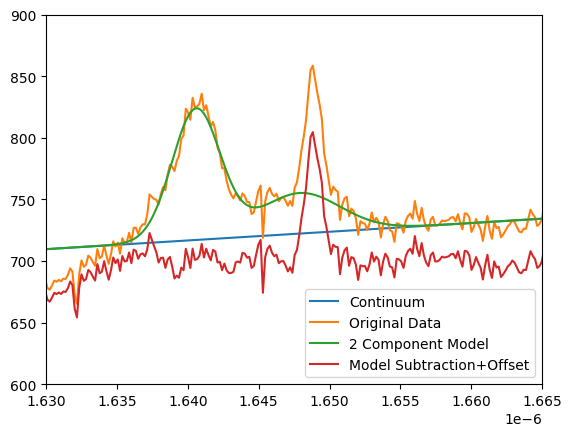

In [43]:
# Make the final plots to illustrate the original spectrum, model fits, and final continuum+gassian subtracted cube
plt.figure()
plt.xlim([1.630E-6, 1.665E-6])
plt.ylim([600, 900])
plt.plot(all_spec.spectral_axis, continuum_data[:, 30, 30], label='Continuum')
plt.plot(all_spec.spectral_axis, original_data[:, 30, 30], label='Original Data')
plt.plot(all_spec.spectral_axis, full_model[:, 30, 30], label='2 Component Model')
plt.plot(all_spec.spectral_axis, final_sub_cube[:, 30, 30]+700, label='Model Subtraction+Offset')
plt.legend()
plt.show()

In [44]:
# Open up a new instance of Cubeviz to visualize continuum subtracted data
cubeviz3 = Cubeviz()
cubeviz3.app

Application(config='cubeviz', docs_link='https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html', events=[…

In [45]:
cont_sub_cube = 'NGC4151_Hband_FinalSubtract.fits'
cubeviz3.app.load_data(cont_sub_cube, data_label='Red/Blue Shift')